In [347]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import random

## Data loader

In [348]:
data_path = "./data/hvgs"
# f_list = os.listdir(data_path)
f_list = ['TCGA-LUNG.csv']
file = os.path.join(data_path, f_list[0])
df = pd.read_csv(file)
x = df.values[:, 3:]
y = df.values[:, 1:3]
seed = 42
duration_max = df.duration.max()
num_pred_points = 1000
duration_reference = [
    duration_max / num_pred_points * i for i in range(num_pred_points)
]

x_train, x_test, y_train, y_test = train_test_split(
    x, y, random_state=42, train_size=0.7
)
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train, y_train, random_state=42, train_size=0.9
)

print(f"x train {x_train.shape}\nx_valid {x_valid.shape}\nx_test {x_test.shape}")

x train (502, 798)
x_valid (56, 798)
x_test (240, 798)


In [349]:
def label_modifier(y):
    y_expand_lab = []
    y_mask = []
    for i, _y in enumerate(y):
        # y_surv.append(_y[1])
        # if i==0:
        y_expand_lab.append((np.array(duration_reference) >= _y[0]) * 1)
        if _y[1] == 0:
            y_mask.append(~(np.array(duration_reference) >= _y[0]) * 1)
        else:
            y_mask.append(np.ones_like(y_expand_lab[-1]))
            # y_expand = np.concatenate([y_expand, (np.array(duration_reference)>=_y[0])*1], axis=0)
    y_expand_lab = torch.tensor(np.array(y_expand_lab).astype(float))
    y_mask = torch.tensor(np.array(y_mask).astype(int))
    return y, y_expand_lab, y_mask

In [350]:
y_train_mask = label_modifier(y_train)
y_valid_mask = label_modifier(y_valid)
y_test_mask = label_modifier(y_test)

In [351]:
class data_process(Dataset):
    def __init__(self, x, y, device="cpu", x_mean=None, x_std=None) -> None:
        super().__init__()
        self.x = torch.tensor(x.astype(np.float32)).to(device)
        self.y_orig = torch.tensor(y[0].astype(int)).to(device)
        self.y = y[1].to(device)
        self.y_mask = y[2].to(device)

        if x_mean is None:
            self.mean = self.x.mean(0)
            self.std = self.x.std(0)
            # self.x = (self.x - self.mean) / self.std
        else:
            self.mean = x_mean
            self.std = x_std
        
        self.x = (self.x - self.mean) / self.std 

    def return_mean_std(self):
        return self.mean, self.std

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx], self.y_mask[idx], self.y_orig[idx]

In [352]:
data_tr = data_process(x_train, y_train_mask)
m, s = data_tr.return_mean_std()
data_val = data_process(x_valid, y_valid_mask, x_mean=m, x_std=s)
data_test = data_process(x_test, y_test_mask, x_mean=m, x_std=s)

In [353]:
dl_train = DataLoader(data_tr, batch_size=32, shuffle=True)
dl_valid = DataLoader(data_val, batch_size=32)
dl_test = DataLoader(data_test, batch_size=32)

In [354]:
class model(nn.Module):
    def __init__(self, inp_size, num_pred_tgt, hidden=[500, 800]):
        super().__init__()
        hidden = [inp_size] + hidden + [num_pred_tgt]
        self.linears = nn.ModuleList(
            [nn.Linear(hidden[i], hidden[i + 1]) for i in range(len(hidden) - 1)]
        )
        self.n_linears = len(self.linears)

    def forward(self, x):
        for i in range(self.n_linears - 1):
            x = self.linears[i](x)
            x = F.relu(x)
        x = self.linears[-1](x)
        return x

In [355]:
loss_fn = nn.BCEWithLogitsLoss(reduction="none")

In [356]:
m = model(x.shape[1], num_pred_points)
optimizer = torch.optim.Adam(m.parameters(), lr=0.0005)

In [359]:
test_batch[1]

tensor([[0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        ...,
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.]], dtype=torch.float64)

In [360]:
for ep in range(10000):
    loss_tr = 0
    for i, tr_batch in enumerate(dl_train):
        m.train()
        optimizer.zero_grad()
        logit = m(tr_batch[0])
        loss = (loss_fn(logit,tr_batch[1]) * tr_batch[2]).mean()
        loss.backward()
        optimizer.step()
        loss_tr+=loss
    # print(loss_tr/(i+1))
    loss_test = 0
    for i, test_batch in enumerate(dl_test):
        m.eval()
        # optimizer.zero_grad()
        logit = m(test_batch[0])
        loss = (loss_fn(logit,test_batch[1]) * test_batch[2]).mean()
        # loss.backward()
        # optimizer.step()
        loss_test+=loss
    if ep%100==0:

        print('Test loss', loss_test/(i+1))

Test loss tensor(69796.8132, dtype=torch.float64, grad_fn=<DivBackward0>)
Test loss tensor(756.4169, dtype=torch.float64, grad_fn=<DivBackward0>)
Test loss tensor(296.2377, dtype=torch.float64, grad_fn=<DivBackward0>)
Test loss tensor(220.0404, dtype=torch.float64, grad_fn=<DivBackward0>)
Test loss tensor(197.1286, dtype=torch.float64, grad_fn=<DivBackward0>)
Test loss tensor(187.0769, dtype=torch.float64, grad_fn=<DivBackward0>)
Test loss tensor(173.5326, dtype=torch.float64, grad_fn=<DivBackward0>)
Test loss tensor(154.9047, dtype=torch.float64, grad_fn=<DivBackward0>)
Test loss tensor(128.7431, dtype=torch.float64, grad_fn=<DivBackward0>)
Test loss tensor(96.4690, dtype=torch.float64, grad_fn=<DivBackward0>)


KeyboardInterrupt: 

In [ ]:
    for i, test_batch in enumerate(dl_test):
        m.eval()
        # optimizer.zero_grad()
        logit = m(test_batch[0])
        loss = (loss_fn(test_batch[1], logit) * test_batch[2]).mean()
        # loss.backward()
        # optimizer.step()
        loss_test+=loss

In [ ]:
logit

tensor([[-0.0847,  0.0524, -0.0235,  ...,  1.2860,  1.0850,  1.0637],
        [ 0.1321,  0.8096, -0.1600,  ...,  5.9836,  4.5919,  5.5155],
        [ 0.0285,  0.3777, -0.0197,  ...,  1.9953,  1.5820,  1.6747],
        ...,
        [-0.0859,  0.3522,  0.0733,  ...,  2.1921,  1.6024,  1.8083],
        [ 0.0062,  0.2223, -0.0444,  ...,  1.3009,  1.1183,  1.1493],
        [ 0.2643,  0.4888, -0.1983,  ...,  3.4846,  3.0441,  3.1446]],
       grad_fn=<AddmmBackward0>)

In [ ]:
loss

tensor(0.3017, grad_fn=<MeanBackward0>)

In [ ]:
(loss * l[2]).shape

torch.Size([32, 1000])

In [ ]:
BCE

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, random_state=42, train_size=0.7
)

In [ ]:
def 

array([[688, 0],
       [628, 1],
       [0, 0],
       [3964, 0],
       [98, 0],
       [661, 0],
       [314, 0],
       [1161, 0],
       [1138, 0],
       [2030, 0],
       [482, 0],
       [456, 0],
       [1970, 1],
       [2615, 0],
       [2830, 0],
       [576, 0],
       [2381, 0],
       [439, 1],
       [808, 0],
       [1456, 0],
       [1092, 0],
       [533, 0],
       [923, 0],
       [1590, 0],
       [356, 0],
       [1045, 0],
       [694, 1],
       [996, 0],
       [1359, 0],
       [1927, 0],
       [1061, 1],
       [605, 1],
       [896, 0],
       [2586, 0],
       [1605, 0],
       [2515, 0],
       [771, 0],
       [1495, 0],
       [1017, 0],
       [22, 0],
       [541, 0],
       [813, 0],
       [3102, 0],
       [133, 0],
       [660, 0],
       [2408, 0],
       [5723, 0],
       [1020, 1],
       [605, 0],
       [505, 0],
       [547, 0],
       [881, 0],
       [245, 1],
       [922, 0],
       [1373, 0],
       [1104, 0],
       [2169, 0],
       [

In [ ]:
x_train.shape

(128, 184)

In [ ]:
x_test.shape

(56, 184)

In [ ]:
import matplotlib.pyplot as plt
from sksurv.datasets import load_whas500
from sksurv.linear_model import CoxPHSurvivalAnalysis

In [ ]:
X, y = load_whas500()
X = X.astype(float)

In [ ]:
X

,afb,age,av3,bmi,chf,cvd,diasbp,gender,hr,los,miord,mitype,sho,sysbp
0,1.0,83.0,0.0,25.54051,0.0,1.0,78.0,0.0,89.0,5.0,1.0,0.0,0.0,152.0
1,0.0,49.0,0.0,24.02398,0.0,1.0,60.0,0.0,84.0,5.0,0.0,1.0,0.0,120.0
2,0.0,70.0,0.0,22.14290,0.0,0.0,88.0,1.0,83.0,5.0,0.0,1.0,0.0,147.0
3,0.0,70.0,0.0,26.63187,1.0,1.0,76.0,0.0,65.0,10.0,0.0,1.0,0.0,123.0
4,0.0,70.0,0.0,24.41255,0.0,1.0,85.0,0.0,63.0,6.0,0.0,1.0,0.0,135.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1.0,76.0,0.0,27.96454,0.0,1.0,88.0,1.0,68.0,1.0,0.0,1.0,0.0,112.0
496,0.0,76.0,0.0,24.26862,0.0,1.0,96.0,1.0,88.0,3.0,0.0,0.0,0.0,208.0
497,1.0,57.0,0.0,42.13576,0.0,1.0,74.0,1.0,123.0,3.0,0.0,0.0,0.0,120.0
498,0.0,67.0,0.0,27.40905,0.0,1.0,62.0,0.0,59.0,1.0,0.0,1.0,0.0,112.0


In [ ]:
estimator = CoxPHSurvivalAnalysis().fit(X, y)

In [ ]:
y

array([(False, 2.178e+03), (False, 2.172e+03), (False, 2.190e+03),
       ( True, 2.970e+02), (False, 2.131e+03), ( True, 1.000e+00),
       (False, 2.122e+03), ( True, 1.496e+03), ( True, 9.200e+02),
       (False, 2.175e+03), (False, 2.173e+03), ( True, 1.671e+03),
       (False, 2.192e+03), ( True, 8.650e+02), (False, 2.166e+03),
       (False, 2.168e+03), ( True, 9.050e+02), ( True, 2.353e+03),
       (False, 2.146e+03), ( True, 6.100e+01), ( True, 2.358e+03),
       (False, 2.114e+03), (False, 2.132e+03), (False, 2.139e+03),
       (False, 2.048e+03), (False, 2.152e+03), ( True, 6.000e+00),
       (False, 2.156e+03), ( True, 1.180e+02), (False, 2.064e+03),
       ( True, 8.490e+02), ( True, 7.140e+02), (False, 2.057e+03),
       ( True, 2.000e+00), ( True, 7.000e+00), (False, 2.151e+03),
       ( True, 6.000e+00), ( True, 4.220e+02), ( True, 3.540e+02),
       (False, 2.065e+03), (False, 2.048e+03), ( True, 1.065e+03),
       ( True, 5.350e+02), (False, 2.118e+03), ( True, 9.700e+

In [ ]:
y[:10]

array([(False, 2.178e+03), (False, 2.172e+03), (False, 2.190e+03),
       ( True, 2.970e+02), (False, 2.131e+03), ( True, 1.000e+00),
       (False, 2.122e+03), ( True, 1.496e+03), ( True, 9.200e+02),
       (False, 2.175e+03)], dtype=[('fstat', '?'), ('lenfol', '<f8')])

In [ ]:
y[3][1] / 2358

0.12595419847328243

In [ ]:
pred_x[-1]

2358.0

In [ ]:
estimator.predict(X.iloc[:10])

array([3.07586148, 1.29704053, 1.82027862, 2.43809602, 1.71853033,
       2.8242479 , 0.21493367, 1.12557932, 3.04750438, 1.433097  ])

In [ ]:
chf_funcs = estimator.predict_cumulative_hazard_function(X.iloc[:10])

In [ ]:
pred_x = []
for v in chf_funcs[0].x:
    pred_x.append(v)

In [ ]:
pred_y = []
for _, v in y:
    pred_y.append(v)

In [ ]:
pred_x

[1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 10.0,
 11.0,
 14.0,
 16.0,
 17.0,
 18.0,
 19.0,
 20.0,
 22.0,
 26.0,
 31.0,
 32.0,
 33.0,
 34.0,
 37.0,
 42.0,
 46.0,
 49.0,
 52.0,
 53.0,
 55.0,
 57.0,
 60.0,
 61.0,
 62.0,
 64.0,
 69.0,
 76.0,
 81.0,
 83.0,
 88.0,
 91.0,
 93.0,
 95.0,
 97.0,
 100.0,
 101.0,
 108.0,
 109.0,
 113.0,
 116.0,
 117.0,
 118.0,
 129.0,
 132.0,
 134.0,
 135.0,
 137.0,
 140.0,
 143.0,
 145.0,
 146.0,
 151.0,
 166.0,
 169.0,
 187.0,
 192.0,
 197.0,
 200.0,
 226.0,
 233.0,
 235.0,
 259.0,
 269.0,
 274.0,
 287.0,
 289.0,
 295.0,
 297.0,
 312.0,
 313.0,
 321.0,
 328.0,
 343.0,
 345.0,
 354.0,
 358.0,
 359.0,
 363.0,
 368.0,
 371.0,
 373.0,
 376.0,
 382.0,
 385.0,
 386.0,
 390.0,
 392.0,
 397.0,
 398.0,
 399.0,
 400.0,
 403.0,
 405.0,
 406.0,
 407.0,
 408.0,
 411.0,
 412.0,
 416.0,
 418.0,
 419.0,
 421.0,
 422.0,
 424.0,
 426.0,
 427.0,
 433.0,
 437.0,
 440.0,
 442.0,
 445.0,
 446.0,
 449.0,
 450.0,
 451.0,
 452.0,
 457.0,
 458.0,
 459.0,
 465.0,
 466.0,
 467.0,
 473.0,
 

In [ ]:
set(sorted(pred_y))

{1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 10.0,
 11.0,
 14.0,
 16.0,
 17.0,
 18.0,
 19.0,
 20.0,
 22.0,
 26.0,
 31.0,
 32.0,
 33.0,
 34.0,
 37.0,
 42.0,
 46.0,
 49.0,
 52.0,
 53.0,
 55.0,
 57.0,
 60.0,
 61.0,
 62.0,
 64.0,
 69.0,
 76.0,
 81.0,
 83.0,
 88.0,
 91.0,
 93.0,
 95.0,
 97.0,
 100.0,
 101.0,
 108.0,
 109.0,
 113.0,
 116.0,
 117.0,
 118.0,
 129.0,
 132.0,
 134.0,
 135.0,
 137.0,
 140.0,
 143.0,
 145.0,
 146.0,
 151.0,
 166.0,
 169.0,
 187.0,
 192.0,
 197.0,
 200.0,
 226.0,
 233.0,
 235.0,
 259.0,
 269.0,
 274.0,
 287.0,
 289.0,
 295.0,
 297.0,
 312.0,
 313.0,
 321.0,
 328.0,
 343.0,
 345.0,
 354.0,
 358.0,
 359.0,
 363.0,
 368.0,
 371.0,
 373.0,
 376.0,
 382.0,
 385.0,
 386.0,
 390.0,
 392.0,
 397.0,
 398.0,
 399.0,
 400.0,
 403.0,
 405.0,
 406.0,
 407.0,
 408.0,
 411.0,
 412.0,
 416.0,
 418.0,
 419.0,
 421.0,
 422.0,
 424.0,
 426.0,
 427.0,
 433.0,
 437.0,
 440.0,
 442.0,
 445.0,
 446.0,
 449.0,
 450.0,
 451.0,
 452.0,
 457.0,
 458.0,
 459.0,
 465.0,
 466.0,
 467.0,
 473.0,
 

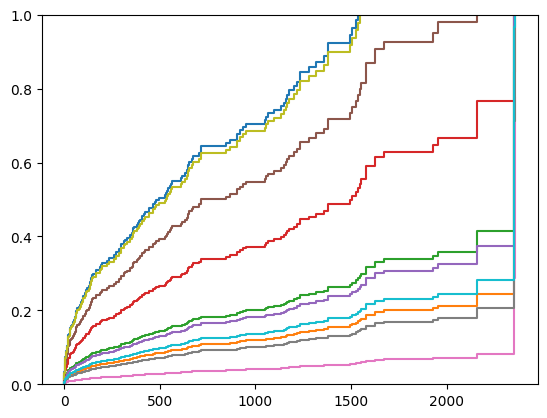

In [ ]:
for fn in chf_funcs:
    plt.step(fn.x, fn(fn.x), where="post")

plt.ylim(0, 1)
plt.show()

In [ ]:
chf_funcs[1]

StepFunction(x=array([1.000e+00, 2.000e+00, 3.000e+00, 4.000e+00, 5.000e+00, 6.000e+00,
       7.000e+00, 1.000e+01, 1.100e+01, 1.400e+01, 1.600e+01, 1.700e+01,
       1.800e+01, 1.900e+01, 2.000e+01, 2.200e+01, 2.600e+01, 3.100e+01,
       3.200e+01, 3.300e+01, 3.400e+01, 3.700e+01, 4.200e+01, 4.600e+01,
       4.900e+01, 5.200e+01, 5.300e+01, 5.500e+01, 5.700e+01, 6.000e+01,
       6.100e+01, 6.200e+01, 6.400e+01, 6.900e+01, 7.600e+01, 8.100e+01,
       8.300e+01, 8.800e+01, 9.100e+01, 9.300e+01, 9.500e+01, 9.700e+01,
       1.000e+02, 1.010e+02, 1.080e+02, 1.090e+02, 1.130e+02, 1.160e+02,
       1.170e+02, 1.180e+02, 1.290e+02, 1.320e+02, 1.340e+02, 1.350e+02,
       1.370e+02, 1.400e+02, 1.430e+02, 1.450e+02, 1.460e+02, 1.510e+02,
       1.660e+02, 1.690e+02, 1.870e+02, 1.920e+02, 1.970e+02, 2.000e+02,
       2.260e+02, 2.330e+02, 2.350e+02, 2.590e+02, 2.690e+02, 2.740e+02,
       2.870e+02, 2.890e+02, 2.950e+02, 2.970e+02, 3.120e+02, 3.130e+02,
       3.210e+02, 3.280e+02, 3.430e+